In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from importlib import reload
import structured_mesh as msh
import evaluations


/tmp/ipykernel_441/1641328221.py:18: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(im)
/tmp/ipykernel_441/1641328221.py:21: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(im)


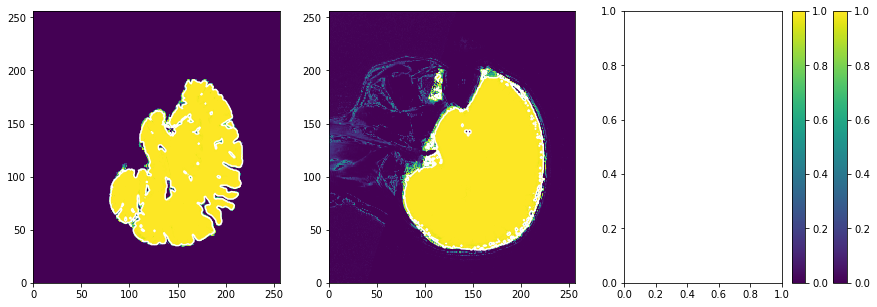

In [2]:

tissue_prob_map = loadmat('/home/anne/Masterarbeit/masterarbeit/2d//data/T1SliceAnne.mat')


white_prob = tissue_prob_map['T1Slice']['white'][0][0]
gray_prob = tissue_prob_map['T1Slice']['gray'][0][0]
csf_prob = tissue_prob_map['T1Slice']['csf'][0][0]
skull_prob = tissue_prob_map['T1Slice']['skull'][0][0]
scalp_prob = tissue_prob_map['T1Slice']['scalp'][0][0]

head =  white_prob + gray_prob + csf_prob + skull_prob # + scalp_prob
inner =  white_prob + gray_prob + csf_prob
brain = white_prob + gray_prob

fig, axis = plt.subplots(1,3, figsize=(15,5))

axis[0].contour(brain, levels=[0.95], colors=['white'])
im = axis[0].pcolor(brain)
fig.colorbar(im) 
axis[1].contour(head, levels=[0.95], colors=['white'])
im = axis[1].pcolor(head)
fig.colorbar(im) 

70
35
18
1.0000000591389835


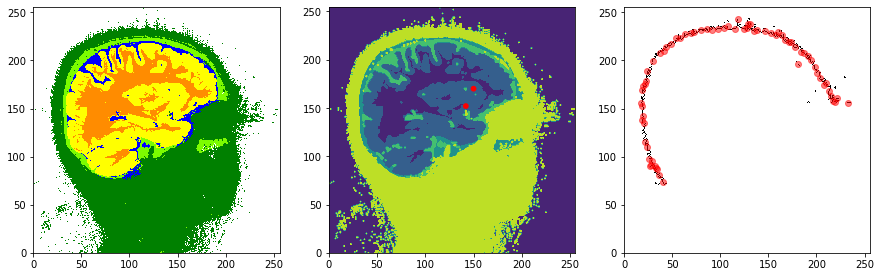

In [3]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

fig, axis = plt.subplots(1,3, figsize=(15,5))

x = np.linspace(0, 1, 256)
y = np.linspace(0, 1, 256)
z = np.ndarray((256,256))
zz = np.ndarray((256,256))
g = np.ndarray((256,256))
s = np.ndarray((256,256))
z1 = np.ndarray((256,256))
boundary = np.zeros((256,256))

for i in range(256):
    for j in range(256):
        probs = [gray_prob[i,j],white_prob[i,j],skull_prob[i,j],csf_prob[i,j],scalp_prob[i,j]]
        g[j,i] = gray_prob[i,j]
        s[j,i] = scalp_prob[i,j]
        if white_prob[i,j]>0.5: 
            z[j,i]=1
        elif gray_prob[i,j]>0.5: 
            z[j,i]=2
        elif skull_prob[i,j]>0.5: 
            z[j,i]=3
        elif csf_prob[i,j]>0.5: 
            z[j,i]=4
        elif scalp_prob[i,j]>0.5: 
            z[j,i]=5
        else:
            z[j,i]=0

for i in range(256):
    for j in range(256):
        probs = [gray_prob[i,j],white_prob[i,j],skull_prob[i,j],csf_prob[i,j],scalp_prob[i,j]]
        if white_prob[i,j]>0.5: 
            z1[j,i]=1
        elif (gray_prob[i,j] + white_prob[i,j])>0.5: 
            z1[j,i]=2
        elif (skull_prob[i,j] + gray_prob[i,j] + white_prob[i,j])>0.5: 
            z1[j,i]=3
        elif (csf_prob[i,j]+skull_prob[i,j] + gray_prob[i,j] + white_prob[i,j])>0.5: 
            z1[j,i]=4
        elif (scalp_prob[i,j]+csf_prob[i,j]+skull_prob[i,j] + gray_prob[i,j] + white_prob[i,j])>0.5: 
            z1[j,i]=5
        else:
            z1[j,i]=0
b = []
for i in range(255):
    for j in range(255):
        if (z[j,i] == 5 
        and (z[j-1,i] == 0 or z[j+1,i] == 0 or z[j,i-1] == 0 or z[j,i+1] == 0)
        and (j>155 or (j>70 and i<45))
        and (z[j-1,i] == 5 or z[j+1,i] == 5 or z[j,i-1] == 5 or z[j,i+1] == 5 or z[j-1,i-1] == 5 or z[j+1,i+1] == 5)):
            boundary[j,i] = 1
            b.append([i,j])
     
cmap = ListedColormap(["white", "darkorange", "yellow", "lawngreen", "blue", "green"])
set = axis[0].pcolor(z1, cmap=cmap)
#set = axis[1].pcolor(z1, cmap=cmap)
set = axis[1].contourf(z1, levels = [0,1,2,3,4,5])
set = axis[2].pcolor(boundary, cmap='Greys')
axis[0].set_aspect(1)
axis[1].set_aspect(1)
axis[2].set_aspect(1)

electrodes_1 = []
electrodes_2 = []
electrodes_3 = []

for k in range(0,len(b),10):
    electrodes_3.append(b[k])

for k in range(0,len(electrodes_3),2):
    electrodes_2.append(electrodes_3[k])

for k in range(0,len(electrodes_2),2):
    electrodes_1.append(electrodes_2[k])

print(len(electrodes_3))
print(len(electrodes_2))
print(len(electrodes_1))

np.savez_compressed("/home/anne/Masterarbeit/masterarbeit/2d/data/electrodes_3.npz", electrodes_3)
np.savez_compressed("/home/anne/Masterarbeit/masterarbeit/2d/data/electrodes_2.npz", electrodes_2)
np.savez_compressed("/home/anne/Masterarbeit/masterarbeit/2d/data/electrodes_1.npz", electrodes_1)

print(g[170,150])
evaluations.draw_point(axis[1], [150,170], alpha=1)
evaluations.draw_point(axis[1], [142,152], alpha=1)


electrodes = np.array(electrodes_3)
axis[2].scatter(electrodes[:,0], electrodes[:,1], c='red', alpha=0.5)

plt.show()


In [4]:
import structured_mesh 
reload(structured_mesh)

center = [128, 128]
center = np.array(center)

path = "/home/anne/Masterarbeit/masterarbeit/2d/data/mesh_hex_16.npz"
mesh = structured_mesh.StructuredMesh(16)

theta = (150,50)
c = mesh.find_next_center(theta)
tissue_prob = mesh.gray_probs[int(c[0]+mesh.cells_per_dim*c[1])]
print(tissue_prob)


Created new mesh with 
 289 nodes 
 256 elements

0.26953126593980414


[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


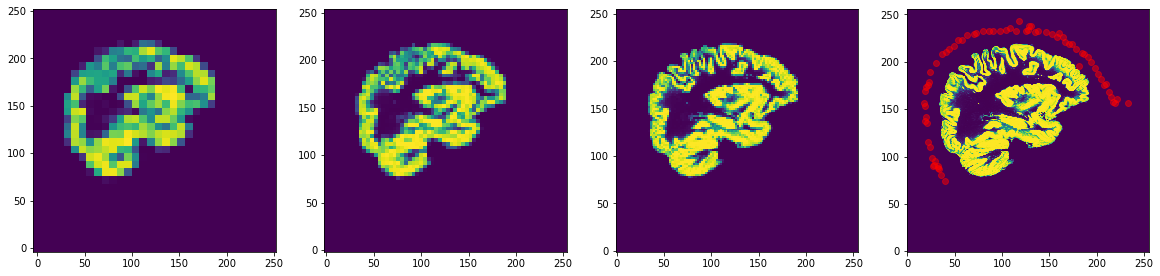

In [5]:
from os import name

fig, axis = plt.subplots(1,4, figsize=(20,5))

paths = [
    "/home/anne/Masterarbeit/masterarbeit/2d/data/mesh_hex_32.npz",
    "/home/anne/Masterarbeit/masterarbeit/2d/data/mesh_hex_64.npz",
    "/home/anne/Masterarbeit/masterarbeit/2d/data/mesh_hex_128.npz",
    "/home/anne/Masterarbeit/masterarbeit/2d/data/mesh_hex_256.npz"]
numbers = [32,64,128,256]

point = [80,80]
for i in range(4):
    n = numbers[i]

    mesh = np.load(paths[i])

    elements = mesh['elements']
    nodes = mesh['nodes']
    labels = mesh['labels']
    gray_probs = mesh['gray_probs']
    print(gray_probs)
    x = np.zeros(n+1)
    y = np.zeros(n+1)
    z = np.ndarray((n,n),float)
    g = np.ndarray((n,n),float)

    x = nodes[:n,0]
    y = nodes[:n,0]

    for k in range(n):
        for j in range(n):
            z[k,j] = labels[k+n*j]
            g[k,j] = gray_probs[k+n*j]

    axis[i].pcolormesh(x,y,g)
    axis[i].set_aspect(1)

    axis[3].scatter(electrodes[:,0], electrodes[:,1], c='red', alpha=0.5)

plt.show()



Created new mesh with 
 1089 nodes 
 1024 elements

[17. 31.]
[248   0]
0.0

Created new mesh with 
 4225 nodes 
 4096 elements

[34. 63.]
[252   0]
0.0

Created new mesh with 
 16641 nodes 
 16384 elements

[ 69. 127.]
[254   0]
0.0

Created new mesh with 
 66049 nodes 
 65536 elements

[138. 254.]
[254   0]
0.0


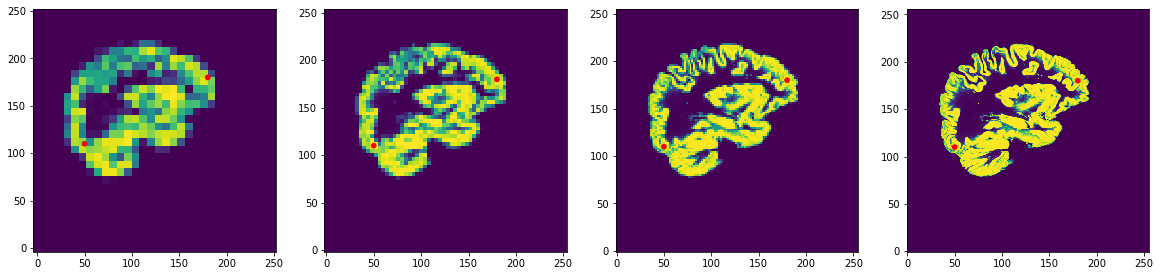

In [6]:
reload(structured_mesh)
from os import name

fig, axis = plt.subplots(1,4, figsize=(20,5))

numbers = [32,64,128,256]
paths = [
    "/home/anne/Masterarbeit/masterarbeit/2d/data/mesh_hex_32.npz",
    "/home/anne/Masterarbeit/masterarbeit/2d/data/mesh_hex_64.npz",
    "/home/anne/Masterarbeit/masterarbeit/2d/data/mesh_hex_128.npz",
    "/home/anne/Masterarbeit/masterarbeit/2d/data/mesh_hex_256.npz"]
    
point = [138.29080783, 254.95993776]
for i in range(4):
    n = numbers[i]

    mesh = msh.StructuredMesh(n, paths[i])
    
    x = np.zeros(n+1)
    y = np.zeros(n+1)
    z = np.ndarray((n,n),float)
    g = np.ndarray((n,n),float)

    x = mesh.nodes[:n,0]
    y = mesh.nodes[:n,0]

    for k in range(n):
        for j in range(n):
            z[k,j] = mesh.labels[k+n*j]
            g[k,j] = mesh.gray_probs[k+n*j]

    axis[i].pcolormesh(x,y,g)
    axis[i].set_aspect(1)

    evaluations.draw_point(axis[i], [180,180], alpha=1)
    evaluations.draw_point(axis[i], [50,110], alpha=1)

    c = mesh.find_next_center(point)
    print(c)
    print(mesh.nodes[int(c[1])])
    print(g[int(c[0]),int(c[1])])



plt.show()